In [1]:
import re
from Bio import SeqIO
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import logomaker
import pybedtools as bt
from scipy import stats

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'

## Testing for evidence of selection on FiNZ-ZnFs
Initially, we extracted seven paralogous clades from a neighbor-joining tree of all sequences, and then tested two models of sequence evolution. The first of these assumes nearly neutral evolution, and constrains $\omega \leq 0$. The alternative hypothesis allows $\omega$ to take on any value. We then carried out likelihood ratio tests comparing the two models for each clade. In 4 out of 7 clades, the model featuring positive selection was favoured over the nearly-neutral model. The results of these tests can be found in supplementary file X.

We then looked at all sites predicted to be under positive selection, with probability greater that 0.5, using naieve empirical Bayes analysis. We intersected these sites with those of base-contacting residues within ZnF arrays, and tested for enrichment of positively-selected sites within base-contacting residues.

In [2]:
merged = []
for i in range(1, 8):
    merged.append(bt.BedTool(f'../data/selection-analysis/clade{i}/clade{i}_c2h2.gff'))
    merged.append(bt.BedTool(f'../data/selection-analysis/clade{i}/clade{i}_psel_neb12.gff'))
merged_bed = merged[0].cat(*merged[1:], force_truncate=False, postmerge=False).sort()
merged_bed = merged_bed.merge(c=3, o='distinct', d=-1)

merged_bed = merged_bed.to_dataframe()
# We restrict our search to ZnF arrays by ignoring the first ~75 sites containing FiNZ and linker sequence.
merged_bed = merged_bed.loc[merged_bed.start >= 75]

psel_base_contacting = len([f for f in merged_bed.name if 'Psel' in f and 'Base-contacting' in f])
psel_nbase_contacting = len([f for f in merged_bed.name if 'Psel' in f and 'Base-contacting' not in f])
npsel_base_contacting = len([f for f in merged_bed.name if 'Psel' not in f and 'Base-contacting' in f])
npsel_nbase_contacting = len([f for f in merged_bed.name if 'Psel' not in f and 'Base-contacting' not in f])

print(f'{psel_base_contacting}\t{npsel_base_contacting}\n{psel_nbase_contacting}\t{npsel_nbase_contacting}')
oddsratio, p = stats.fisher_exact([[psel_base_contacting, npsel_base_contacting], 
                                   [psel_nbase_contacting, npsel_nbase_contacting]])
print(f'odds ratio = {oddsratio}')
print(f'p = {p}')

22	319
39	1405
odds ratio = 2.484526967285588
p = 0.001399842434367778


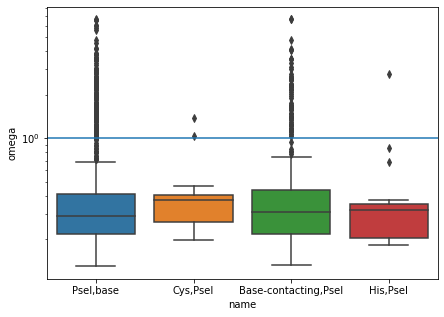

In [3]:
merged = []
for i in range(1, 8):
    merged.append(bt.BedTool(f'../data/selection-analysis/clade{i}/clade{i}_c2h2.gff'))
    merged.append(bt.BedTool(f'../data/selection-analysis/clade{i}/clade{i}_rst_neb12.gff'))
merged_bed = merged[0].cat(*merged[1:], force_truncate=False, postmerge=False).sort()
merged_bed = merged_bed.merge(c=[3, 6, 9], o=['distinct', 'max', 'distinct'], d=-1)

rst_df = merged_bed.to_dataframe()
rst_df = rst_df.rename({'score': 'omega', 'strand': 'prob'}, axis=1)
rst_df['prob'] = rst_df['prob'].apply(lambda x: float(x.strip('.,Pr:')))

fig, ax = plt.subplots(figsize=(7,5))
sns.boxplot(data=rst_df, x='name', y='omega')
ax.axhline(y=1)
ax.set_yscale('log')

In [78]:
def extract_fingers():
    znf_pat = re.compile('C.{2,4}C.{8,15}H.{3,5}H')
    species_pat = re.compile('([A-z]+_[a-z]+)_.*')
    fingers = defaultdict(list)
    
    for record in SeqIO.parse('../data/seqs/cypriniformes_augustus_finz.fa',
                              'fasta'):
        species = re.match(species_pat, record.id).group(1)
        hits = re.findall(znf_pat, str(record.seq))
        for hit in hits:
            fingers[species].append(hit)
    return fingers

def entropy(position):
    return -sum(position.apply(lambda x: x*np.log2(x)))

In [24]:
fingers = extract_fingers()
c = 0
for i in fingers.values():
    c += len(i)
print('ZnFs =', c)

ZnFs = 59965


6238


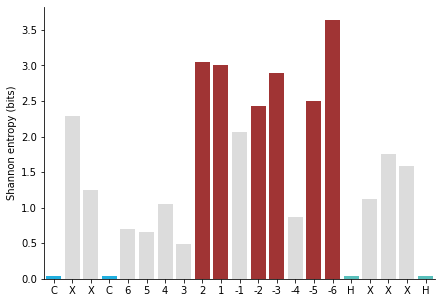

In [25]:
fingers21 = [f for f in fingers['Danio_rerio'] if len(f) == 21]
print(len(fingers21))
mat_df = logomaker.alignment_to_matrix(fingers21, to_type='probability').T
data = defaultdict(list)
for col in mat_df.columns:
    data['position'].append(col)
    data['entropy'].append(entropy(mat_df[col]))
    
znf_df = pd.DataFrame(data)
znf_df['pos_labels'] = ['C', 'X', 'X', 'C', 6, 5, 4, 3, 2, 1, -1, -2, -3, -4, -5, -6, 'H', 'X', 'X', 'X', 'H']
znf_df['colours'] = ['deepskyblue', 'gainsboro', 'gainsboro', 'deepskyblue', 
                     'gainsboro', 'gainsboro', 'gainsboro', 'gainsboro', 'firebrick', 'firebrick',
                     'gainsboro', 'firebrick', 'firebrick', 'gainsboro', 'firebrick', 'firebrick',
                     'mediumturquoise', 'gainsboro', 'gainsboro', 'gainsboro', 'mediumturquoise'] 

fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(data=znf_df, x='position', y='entropy', palette=znf_df.colours)
ax.set_xlabel('')
ax.set_ylabel('Shannon entropy (bits)')
ax.set_xticklabels(znf_df.pos_labels)
sns.despine()
plt.show()
fig.savefig('../figs/Danio_rerio_znf_entropy.pdf', bbox_inches='tight', dpi=300)

If we assume that measured entropy is indpendent of position within the zinc-finger fold, we can calculate the probability of observing that positions with the six highest entropy values would fall on positions 2,1,-2,-3,-5 and -6 by chance alone.

$P(binding = highest) = \frac{6!\times6!}{12!} = 0.00108$

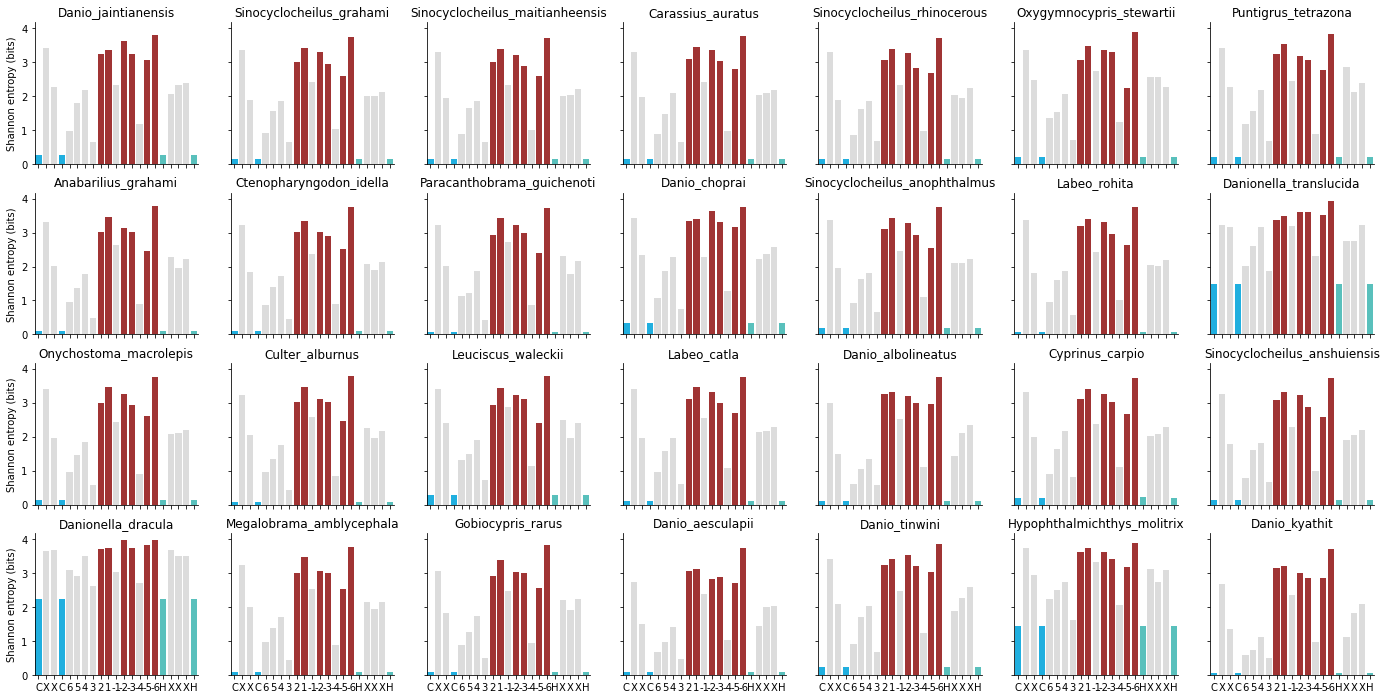

In [26]:
fig, ax = plt.subplots(figsize=(24, 12), nrows=4, ncols=7, sharex=True, sharey=True)
i, j = 0, 0
for species in fingers:
    if species == 'Danio_rerio':
        continue
    fingers21 = [f for f in fingers[species] if len(f) == 21]
    mat_df = logomaker.alignment_to_matrix(fingers21, to_type='probability').T
    data = defaultdict(list)
    for col in mat_df.columns:
        data['position'].append(col)
        data['entropy'].append(entropy(mat_df[col]))
    znf_df = pd.DataFrame(data)
    znf_df['pos_labels'] = ['C', 'X', 'X', 'C', 6, 5, 4, 3, 2, 1, -1, -2, -3, -4, -5, -6, 'H', 'X', 'X', 'X', 'H']
    znf_df['colours'] = ['deepskyblue', 'gainsboro', 'gainsboro', 'deepskyblue', 
                         'gainsboro', 'gainsboro', 'gainsboro', 'gainsboro', 'firebrick', 'firebrick',
                         'gainsboro', 'firebrick', 'firebrick', 'gainsboro', 'firebrick', 'firebrick',
                         'mediumturquoise', 'gainsboro', 'gainsboro', 'gainsboro', 'mediumturquoise']
    sns.barplot(data=znf_df, x='position', y='entropy', palette=znf_df.colours, ax=ax[i][j])
    ax[i][j].set_title(species)
    ax[i][j].set_xlabel('')
    if i == 3: 
        ax[i][j].set_xticklabels(znf_df.pos_labels)
    if j != 0:
        ax[i][j].set_ylabel('')
    else:
        ax[i][j].set_ylabel('Shannon entropy (bits)')
    i += 1
    if i >= 4:
        j += 1
        i = 0
sns.despine()
plt.show()
fig.savefig('../figs/cyprinid_znf_entropy.pdf', bbox_inches='tight', dpi=300)

In [27]:
def footprint(seq):
    znf1 = re.compile('C..C.{8,15}H...H')
    fp_index = (-13, -12, -10, -9, -7, -6)
    hits = re.findall(znf1, seq)
    
    footprint = []
    for hit in hits:
        footprint.append(''.join([hit[i] for i in fp_index]))
    return tuple(footprint)

def extract_footprints(min_znfs=3):
    footprints = {}
    for record in SeqIO.parse('../data/seqs/cypriniformes_augustus_finz.fa',
                              'fasta'):
        fp = footprint(str(record.seq))
        if len(fp) >= min_znfs:
            footprints[record.id] = fp
    return footprints

(0.1, 400)

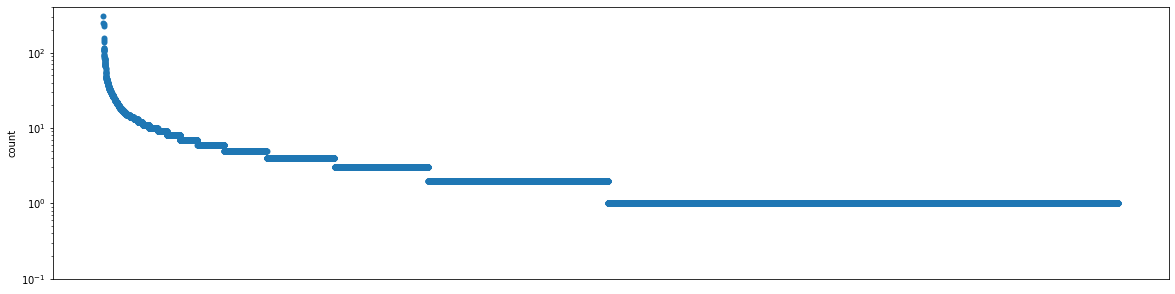

In [28]:
fps = extract_footprints()
all_fps = defaultdict(int)
for key, val in fps.items():
    pretty_fp = ','.join(val)
    for i in val:
        all_fps[i] += 1
data = pd.DataFrame({'footprint': [i for i in all_fps.keys()],
                     'count': [all_fps[i] for i in all_fps.keys()]}) \
         .sort_values('count', ascending=False) 

fig, ax = plt.subplots(figsize=(20, 5))
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yscale('log')
sns.scatterplot(data=data, x='footprint', y='count', linewidth=0)
ax.set_ylim((0.1, 400))
# print(all_fps)        
# for i in sorted(all_fps.items(), key=lambda x: x[1]):
#     print(i[0], i[1])
# print(len(all_fps))
# print(sum(all_fps.values()))